# WSI - ćwiczenie 1.
### Zagadnienie przeszukiwania i podstawowe podejścia do niego


In [10]:
import numpy as np
from matplotlib import pyplot as plt
import math


In [11]:
def f(x):
    return 10*(x**4) + 3*(x**3) - 30*(x**2) + 10*x 

In [12]:
def g(vect):
    assert len(vect) == 2
    return 10*(vect[1]**4) + 10*(vect[0]**4) + 3*(vect[0]**3) - 30*(vect[0]**2) + 10*vect[0]

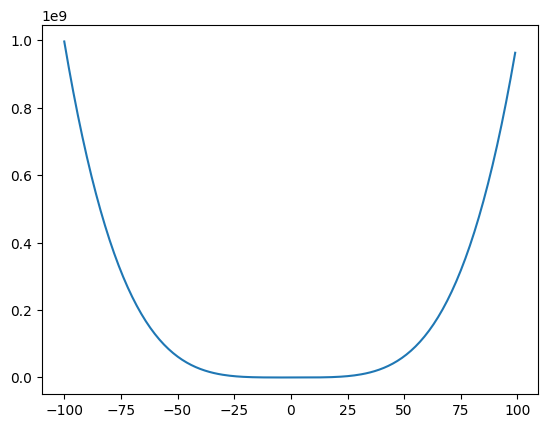

In [17]:
X1 = np.arange(-100, 100, 1)
Y1 = [f(x) for x in X1]
plt.tight_layout()
plt.plot(X1, Y1)

Text(0.5, 0, 'z')

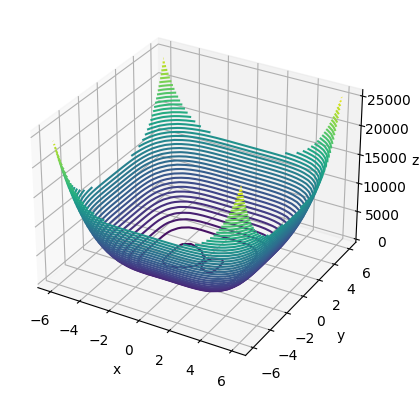

In [33]:
X, Y = np.meshgrid(np.linspace(-6, 6, 30), np.linspace(-6, 6, 30))
Z = [g([x, y]) for x, y in zip(X, Y)]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#plotly do wizualizacji kroków